## Checklist
1. frame the problem and look at the big picture
2. get data
3. EDA
4. Prepare Data for ML Algo
5. Model Selection (Linear Regression)
6. Finetuning and Combining models
7. Present Solution
8. Launch monitor and maintain system


In [127]:
# Imports
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## 1. frame the problem and look at the big picture

### Defining a Goal
> Predicting a houses median price
- Typical Regression Task

### Selecting a Performance Measure
Root mean square error

### Checking Assumptions
Sense Checking goal and performance measure with the dataset.

## 2. get data

In [128]:
# https://www.kaggle.com/datasets/camnugent/california-housing-prices

with open('./data/housing.csv') as file:
    df_raw = pd.read_csv(file)
    
df_raw.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [129]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


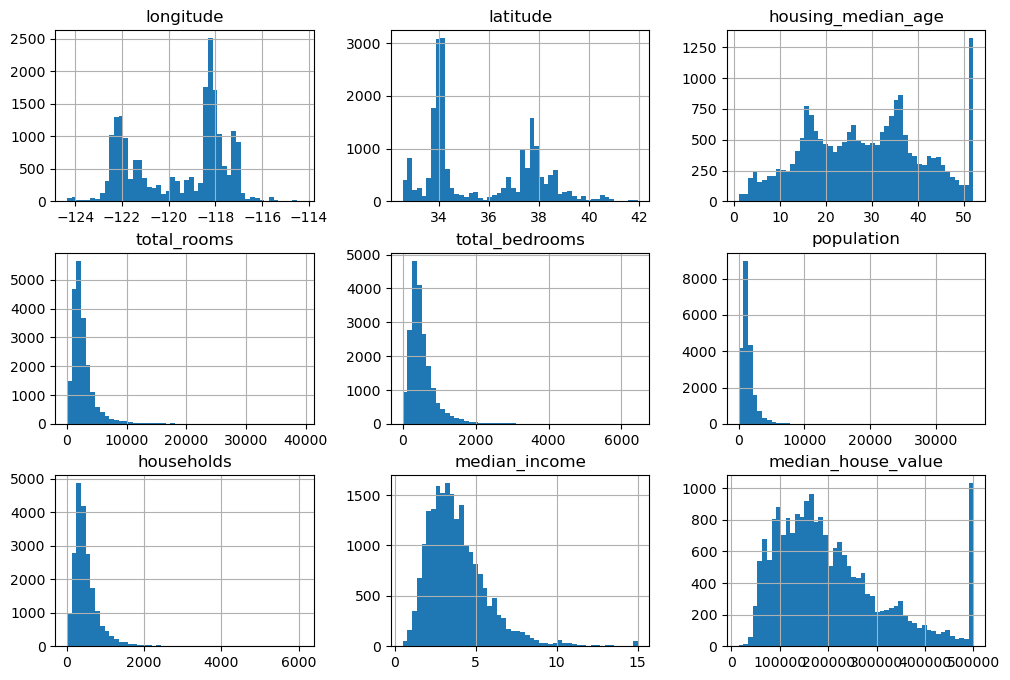

In [130]:
df_raw.hist(bins=50, figsize=(12,8))
plt.show()

In [131]:
df_raw.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


1. Having an initial look at the data
- skewness of data
- sides are clipped (all prices over 15000 are bunched together)
2. Then performing some initial data cleaning
- removing clipped values as we want to predict larger values -> (also from testing set as model should not be penalized for such predictions)


In [132]:
# remap categorical values to numbers
df_raw['ocean_proximity'].value_counts()
df_raw['ocean_proximity'] = df_raw['ocean_proximity'].map({'<1H OCEAN': 0, 'INLAND': 1, 'ISLAND': 2, 'NEAR BAY': 3, 'NEAR OCEAN': 4})

# removing clipped values
boolean_mask = df_raw['median_house_value'] < 500000
df_raw = df_raw[boolean_mask]
df_raw.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,19648.000000,19648.000000,19648.000000,19648.000000,19448.000000,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000
mean,-119.562378,35.651872,28.373066,2620.337693,539.645825,1441.368485,501.192488,3.676411,192055.328583,1.147445
std,2.005760,2.150066,12.504050,2182.371939,422.553057,1144.075196,383.391367,1.570602,97110.854998,1.399086
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.000000
25%,-121.760000,33.930000,18.000000,1438.000000,297.000000,796.000000,282.000000,2.526300,116475.000000,0.000000
50%,-118.500000,34.270000,28.000000,2111.000000,436.000000,1179.000000,411.000000,3.449050,173600.000000,1.000000
75%,-117.990000,37.730000,37.000000,3121.000000,648.000000,1746.250000,606.000000,4.582500,247900.000000,1.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,499100.000000,4.000000


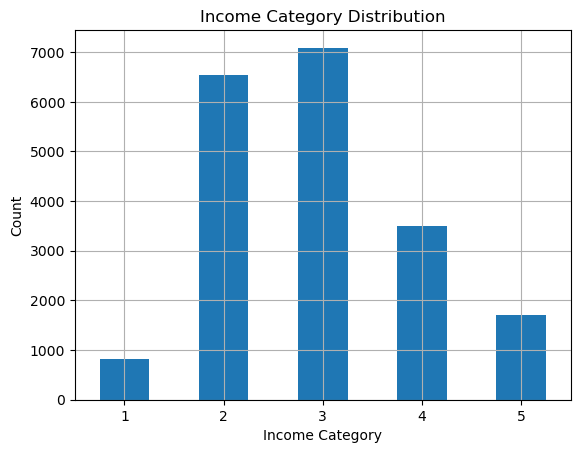

In [133]:
# train test split: 80% train, 20% test stratified to avoid sampling bias due to small dataset

df_raw['income_cat'] = pd.cut(df_raw['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

# Plotting histogram of income category distribution
df_raw['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.title('Income Category Distribution')
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.show()

from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(df_raw, test_size=0.2, random_state=42, stratify=df_raw['income_cat']) #stratifies by bins created in income_cat

# Dropping income_cat column from train and test sets
for _set in (strat_train_set, strat_test_set):
    _set.drop('income_cat', axis=1, inplace=True)


## 3. EDA

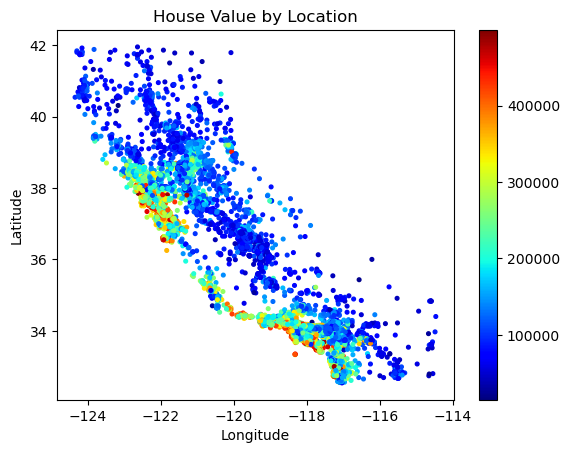

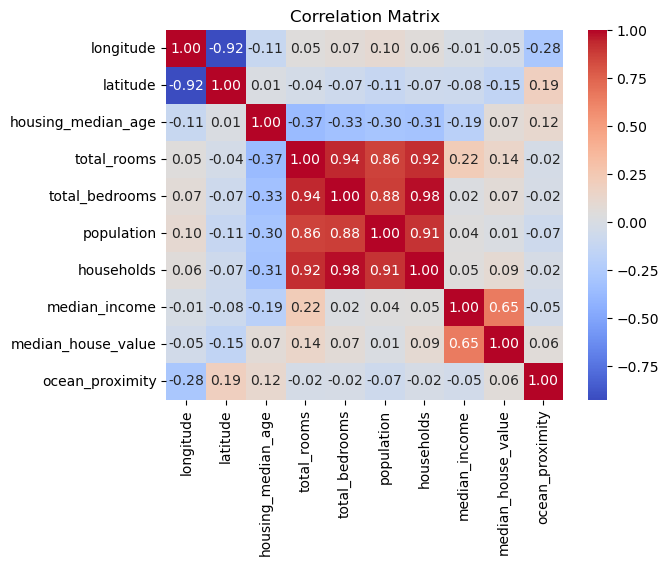

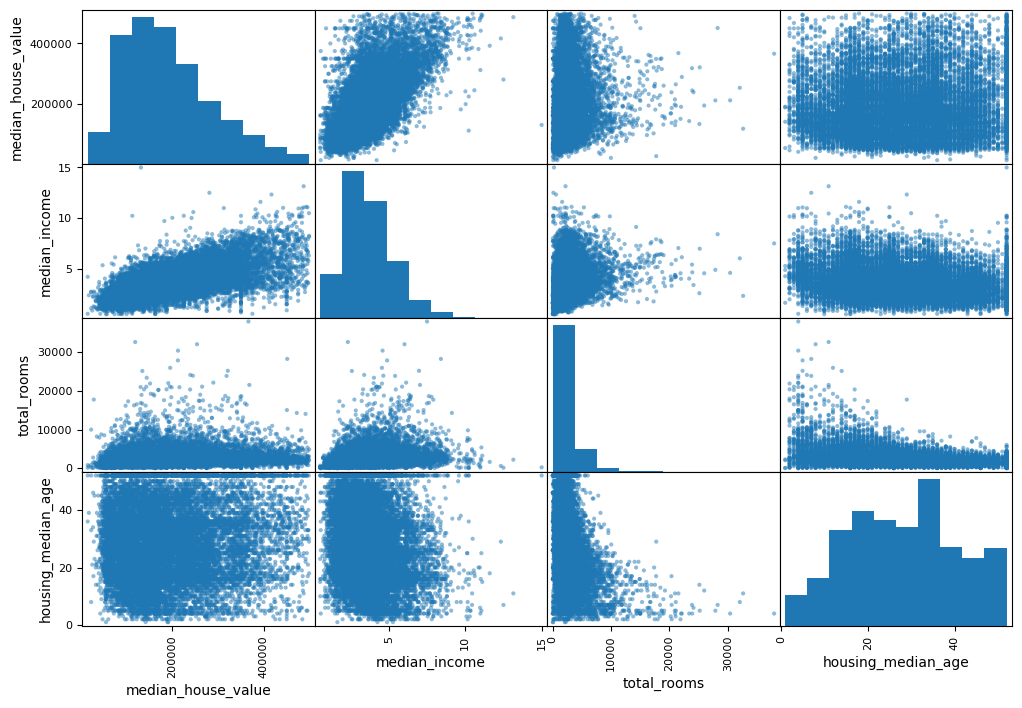

In [134]:
# 1. Visualiztation

# lon vs lat coloring by house value
plt.scatter(data=strat_train_set, x='longitude', y='latitude', alpha=1, s=7,c='median_house_value', cmap='jet')
plt.colorbar()
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('House Value by Location')
plt.show()

# 2. Correlations
corr_matrix = strat_train_set.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(strat_train_set[attributes], figsize=(12,8))
plt.show()

In [135]:
# combining features
strat_train_set['*rooms_per_house'] = strat_train_set['total_rooms'] / strat_train_set['households']
strat_train_set['*bedrooms_vs_total_Rooms'] = strat_train_set['total_bedrooms'] / strat_train_set['total_rooms']
strat_train_set['*people_per_house'] = strat_train_set['population'] / strat_train_set['households']

corr_matrix = strat_train_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.649208
total_rooms                 0.142174
*rooms_per_house            0.111215
households                  0.092148
total_bedrooms              0.072071
housing_median_age          0.068357
ocean_proximity             0.060895
population                  0.010607
*people_per_house          -0.028756
longitude                  -0.046475
latitude                   -0.148557
*bedrooms_vs_total_Rooms   -0.218773
Name: median_house_value, dtype: float64

## 4. Prepare data for ML algo

## 5. Model Selection

## 6. Finetuning and Combining models

## 7. Present Solution

## 8. Launch monitor and maintain system